# Librerías

In [1]:
# Importamos las librerías
import os, logging

# Guardar los datos
import pickle

from matplotlib.pyplot import (
    matshow,
    colorbar,
    xlabel,
    ylabel,
    plot,
    legend,
    grid,
)

from niftypet import nipet

import matplotlib.pyplot as plt
import time as tm

from os import path
import time as tm
import functools
from scipy.ndimage.filters import gaussian_filter
import numpy as np
from tqdm.auto import trange

logging.basicConfig(level=logging.WARN)
mMRpars = nipet.get_mmrparams()

# Medidas para calcular las diferencias
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

/tmp/ipykernel_2552/2009836677.py:25: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


## Funciones adicionales

In [2]:
def div_nzer(x, y):
    return np.divide(x, y, out=np.zeros_like(y), where=y!=0)

def recortar(x):
    return x[100:-120, 110:-110]

def recorta2(x):
    return x[25:,95:-125]


# Carga de datos

# MLEM

## Carga de datos

In [3]:
# Ab_PET_mMR_test
folderin = '/mnt/test1dev/TIC/00Datos/amyloidPET_FBP_TP0'
folderout = "."  # realtive to `{folderin}/niftyout`
itr = 7  # number of iterations (will be multiplied by 14 for MLEM)
fwhm = 2.5  # mm (for resolution modelling)
totCnt = None  # bootstrap sample (e.g. `300e6`) counts

In [4]:
# datain
folderin = path.expanduser(folderin)

# automatically categorise the input data
datain = nipet.classify_input(folderin, mMRpars, recurse=-1)

# output path
opth = path.join(datain['corepath'], "niftyout")

datain

{'corepath': '/mnt/test1dev/TIC/00Datos/amyloidPET_FBP_TP0',
 'lm_dcm': '/mnt/test1dev/TIC/00Datos/amyloidPET_FBP_TP0/LM/17598013_1946_20150604155500.000000.dcm',
 'lm_bf': '/mnt/test1dev/TIC/00Datos/amyloidPET_FBP_TP0/LM/17598013_1946_20150604155500.000000.bf',
 'hmumap': '/mnt/test1dev/TIC/00Datos/amyloidPET_FBP_TP0/output/mumap-hdw/hmumap.npz',
 'sinos': '/mnt/test1dev/TIC/00Datos/amyloidPET_FBP_TP0/niftyout/sino/sinos_s11_frm-0-0.npz',
 'nrm_dcm': '/mnt/test1dev/TIC/00Datos/amyloidPET_FBP_TP0/norm/17598013_1946_20150604082431.000000.dcm',
 'nrm_bf': '/mnt/test1dev/TIC/00Datos/amyloidPET_FBP_TP0/norm/17598013_1946_20150604082431.000000.bf',
 'mumapDCM': '/mnt/test1dev/TIC/00Datos/amyloidPET_FBP_TP0/umap',
 '#mumapDCM': 192}

In [5]:
SIGMA2FWHMmm = (8 * np.log(2))**0.5 * np.array([mMRpars['Cnt']['SO_VX' + i] for i in 'ZYX']) * 10

## Mapas de atenuación

In [6]:
mu_h = nipet.hdw_mumap(datain, [1,2,4], mMRpars, outpath=opth, use_stored=True)
mu_o = nipet.obj_mumap(datain, mMRpars, outpath=opth, store=True)

Chris Rorden's dcm2niiX version v1.0.20220505  GCC9.4.0 x86-64 (64-bit Linux)
Found 192 DICOM file(s)
Convert 192 DICOM as /mnt/test1dev/TIC/00Datos/amyloidPET_FBP_TP0/niftyout/mumap-obj/converted-from-object-DICOM_2024-7-24_14h17_e2 (192x192x192x1)
Conversion required 14.462265 seconds (0.244805 for core code).


## Creamos el histograma

La función mmrhist del módulo NiftyPET se utiliza para procesar datos en modo lista y obtener datos histogramados, también conocidos como sinogramas, además de otras estadísticas de adquisición. Esta función es una parte crucial del flujo de trabajo de procesamiento de datos PET/MR, que convierte grandes cantidades de datos en bruto en formatos más manejables para su análisis.

El uso típico de mmrhist implica proporcionar los datos de entrada categorizados y los parámetros específicos del escáner (mMRpars). Una vez ejecutada, mmrhist genera sinogramas directos y oblicuos que pueden visualizarse para análisis posteriores. Estos sinogramas son esenciales para reconstruir imágenes PET de alta calidad y realizar análisis cuantitativos precisos.

Por ejemplo, para visualizar un sinograma directo generado por mmrhist, se puede elegir un índice de sinograma (por debajo de 127 para sinogramas directos y 127 o más para sinogramas oblicuos) y utilizar herramientas de visualización como matshow de matplotlib para observar los datos​ 

In [7]:
mMRpars['Cnt']['BTP'] = 0
m = nipet.mmrhist(datain, mMRpars, outpath=opth, store=True, use_stored=True)

## Pasos previos para la reconstrucción

La función frwd_prj del módulo NiftyPET en NIPET se utiliza para calcular la proyección directa de una imagen de entrada, generando un conjunto de sinogramas. Esta función es esencial para la reconstrucción de imágenes PET, ya que permite transformar una imagen del espacio real al espacio de sinogramas, que es el formato de datos utilizado para procesar y reconstruir imágenes PET.

In [8]:
A = nipet.frwd_prj(mu_h['im'] + mu_o['im'], mMRpars, attenuation=True)
N = nipet.mmrnorm.get_norm_sino(datain, mMRpars, m)
AN = A * N

i> using CUDA device #0
i> put gaps in and reorder sino...DONE in 0.002141s.
i> calculating normalisation sinogram using device #0... DONE in 0.265370s.
i> using CUDA device #0
i> put gaps in and reorder sino...DONE in 0.002044s.


In [9]:
# Calculate forward projection for the provided input image.
sim = nipet.back_prj(AN, mMRpars)
msk = nipet.img.mmrimg.get_cylinder(mMRpars['Cnt'], rad=29., xo=0., yo=0., unival=1, gpu_dim=False) <= 0.9

# Get the estimated sinogram of random events using the delayed event measurement.  The delayed sinogram is in the histogram dictionary obtained from the processing of the list-mode data.
r = nipet.randoms(m, mMRpars)[0]
print("Randoms: %.3g%%" % (r.sum() / m['psino'].sum() * 100))

eim = nipet.mmrchain(datain, mMRpars, mu_h=mu_h, mu_o=mu_o, histo=m, itr=1, outpath=opth)['im']

"""
Obtain a scatter sinogram using the mu-maps (hardware and object mu-maps) an estimate of emission image, the prompt measured sinogram, an estimate of the randoms sinogram and a normalisation sinogram.
"""
s = nipet.vsm(datain, (mu_h['im'], mu_o['im']), eim, mMRpars, m, r)
print("Scatter: %.3g%%" % (s.sum() / m['psino'].sum() * 100))

i> using CUDA device #0
i> and removing the gaps and reordering sino for GPU... DONE in 0.063551s
i> using CUDA device #0

i> estimating random events (variance reduction)...  DONE in 0.136200s.
Randoms: 52.1%
i> using CUDA device #0
i> and removing the gaps and reordering sino for GPU... DONE in 0.063815s
i> calculating normalisation sinogram using device #0... DONE in 0.267846s.
i> using CUDA device #0

i> estimating random events (variance reduction)...  DONE in 0.136997s.
i> using CUDA device #0
i> and removing the gaps and reordering sino for GPU... DONE in 0.063936s
i> using CUDA device #0
i> precalculating attenuation paths into LUT...DONE in 0.970619s.
i> calculating scatter probabilities for 17947 emission voxels using device #0...DONE in 6.830137s.


i> TOTAL SCATTER TIME: 7.848418
i> using CUDA device #0
i> put gaps in and reorder sino...DONE in 0.009730s.
i> calculating normalisation sinogram using device #0... DONE in 0.137803s.
i> using CUDA device #0
i> put gaps in and r

## Realizamos la reconstrucción

In [10]:
psf = functools.partial(gaussian_filter, sigma=fwhm / SIGMA2FWHMmm)
sim_inv = div_nzer(1, psf(sim))
sim_inv[msk] = 0
rs_AN = div_nzer(r + s, AN)
recon_mlem = [np.ones_like(sim)]

In [11]:
def normalizar_imagen(imagen):
    return (imagen - np.min(imagen)) / (
        np.max(imagen) - np.min(imagen)
        if np.max(imagen) - np.min(imagen) != 0
        else 1
    )

In [12]:
def calcular_parametro_parada(datos_reconstrucción,datos_iteraciones,modo="full", criterio="SSIM"):
    
    dato_anterior = datos_reconstrucción[-2]
    dato_actual = datos_reconstrucción[-1]

    # normalizamos los datos
    dato_anterior = normalizar_imagen(dato_anterior)
    dato_actual = normalizar_imagen(dato_actual)

    if modo == "full":
        dimensiones_imagen = dato_anterior.shape
        dimension_1 = dimensiones_imagen[0]
        dimension_2 = dimensiones_imagen[1]
        dimension_3 = dimensiones_imagen[2]

        # Obtenemos 3 muestras igualmente espaciadas en cada dimensión
        muestras_dimension_1 = [dimension_1//4, 2*dimension_1//4, 3*dimension_1//4]
        muestras_dimension_2 = [dimension_2//4, 2*dimension_2//4, 3*dimension_2//4]
        muestras_dimension_3 = [dimension_3//4, 2*dimension_3//4, 3*dimension_3//4]

        # Calculamos los criterios en cada dimensión
        # MSE
        criterio_MSE_dimension_1 =[]

        for i in muestras_dimension_1:
            criterio_MSE_dimension_1.append(mean_squared_error(dato_anterior[i,:,:], dato_actual[i,:,:]))

        criterio_MSE_1 = np.mean(criterio_MSE_dimension_1)
        
        criterio_MSE_dimension_2 =[]
        for i in muestras_dimension_2:
            criterio_MSE_dimension_2.append(mean_squared_error(dato_anterior[:,i,:], dato_actual[:,i,:]))
        
        criterio_MSE_2 = np.mean(criterio_MSE_dimension_2)

        criterio_MSE_dimension_3 =[]
        for i in muestras_dimension_3:
            criterio_MSE_dimension_3.append(mean_squared_error(dato_anterior[:,:,i], dato_actual[:,:,i]))
        
        criterio_MSE_3 = np.mean(criterio_MSE_dimension_3)

        criterio_MSE = np.mean([criterio_MSE_1,criterio_MSE_2,criterio_MSE_3])

        print(criterio_MSE)

        # PSNR
        criterio_PSNR_dimension_1 =[]
        for i in muestras_dimension_1:
            criterio_PSNR_dimension_1.append(peak_signal_noise_ratio(dato_anterior[i,:,:], dato_actual[i,:,:],data_range=1))
        
        criterio_PSNR_1 = np.mean(criterio_PSNR_dimension_1)

        criterio_PSNR_dimension_2 =[]

        for i in muestras_dimension_2:
            criterio_PSNR_dimension_2.append(peak_signal_noise_ratio(dato_anterior[:,i,:], dato_actual[:,i,:],data_range=1))
        
        criterio_PSNR_2 = np.mean(criterio_PSNR_dimension_2)

        criterio_PSNR_dimension_3 =[]

        for i in muestras_dimension_3:
            criterio_PSNR_dimension_3.append(peak_signal_noise_ratio(dato_anterior[:,:,i], dato_actual[:,:,i],data_range=1))

        criterio_PSNR_3 = np.mean(criterio_PSNR_dimension_3)

        criterio_PSNR = np.mean([criterio_PSNR_1,criterio_PSNR_2,criterio_PSNR_3])

        # SSIM

        criterio_SSIM_dimension_1 =[]

        for i in muestras_dimension_1:
            criterio_SSIM_dimension_1.append(structural_similarity(dato_anterior[i,:,:], dato_actual[i,:,:],data_range=1))

        print(criterio_SSIM_dimension_1)

        criterio_SSIM_1 = np.mean(criterio_SSIM_dimension_1)

        criterio_SSIM_dimension_2 =[]

        for i in muestras_dimension_2:
            criterio_SSIM_dimension_2.append(structural_similarity(dato_anterior[:,i,:], dato_actual[:,i,:],data_range=1))

        criterio_SSIM_2 = np.mean(criterio_SSIM_dimension_2)

        criterio_SSIM_dimension_3 =[]

        for i in muestras_dimension_3:
            criterio_SSIM_dimension_3.append(structural_similarity(dato_anterior[:,:,i], dato_actual[:,:,i],data_range=1))

        criterio_SSIM_3 = np.mean(criterio_SSIM_dimension_3)

        criterio_SSIM = np.mean([criterio_SSIM_1,criterio_SSIM_2,criterio_SSIM_3])

    datos_criterios = {
        "MSE": criterio_MSE,
        "PSNR": criterio_PSNR,
        "SSIM": criterio_SSIM,
    }

    diferenica_MSE = np.abs(datos_iteraciones[-1]["MSE"] - criterio_MSE)
    diferenica_PSNR = np.abs(datos_iteraciones[-1]["PSNR"] - criterio_PSNR)
    diferenica_SSIM = np.abs(datos_iteraciones[-1]["SSIM"] - criterio_SSIM)

    valor_criterio_evaluacion = 0

    if criterio == "MSE":
        valor_criterio_evaluacion = diferenica_MSE
    elif criterio == "PSNR":
        valor_criterio_evaluacion = diferenica_PSNR
    elif criterio == "SSIM":
        valor_criterio_evaluacion = diferenica_SSIM

    return datos_criterios, valor_criterio_evaluacion

In [34]:
datos_iteraciones = [{
        "iteracion" : -1,
        "tiempo_iteracion" : 0,
        "MSE": 0,
        "PSNR": 0,
        "SSIM": 0,
    }]

iteracion = 1
criterio_parada_mlem = 1
tolerancia = 1e-7 
recon_mlem = [np.ones_like(sim)]

while (criterio_parada_mlem > tolerancia):

    t0 = tm.time()

    fprj = nipet.frwd_prj(psf(recon_mlem[-1]), mMRpars) + rs_AN
    recon_mlem.append(
        recon_mlem[-1]
        * sim_inv
        * psf(nipet.back_prj(div_nzer(m["psino"], fprj), mMRpars))
    )

    tiempo_final = tm.time() - t0
    
    
    datos_criterios_mlem,criterio_parada_mlem = calcular_parametro_parada(recon_mlem, datos_iteraciones)

    datos_criterios_mlem["iteracion"] = iteracion
    datos_criterios_mlem["tiempo_iteracion"] = tiempo_final

    print(datos_criterios_mlem)

    datos_iteraciones.append(datos_criterios_mlem)

    iteracion += 1

i> using CUDA device #0
i> put gaps in and reorder sino...DONE in 0.002077s.
i> using CUDA device #0
i> and removing the gaps and reordering sino for GPU... DONE in 0.074990s
0.031701969214307256
[0.4633208322237756, 0.45170320960441623, 0.44625089415799885]
{'MSE': 0.031701969214307256, 'PSNR': 18.671386065183754, 'SSIM': 0.3473150623277852, 'iteracion': 1, 'tiempo_iteracion': 5.314671516418457}
i> using CUDA device #0
i> put gaps in and reorder sino...DONE in 0.002076s.
i> using CUDA device #0
i> and removing the gaps and reordering sino for GPU... DONE in 0.075164s
0.0040930603046129095
[0.7125275915479535, 0.7424749821901346, 0.7498942095851419]
{'MSE': 0.0040930603046129095, 'PSNR': 24.555319254210076, 'SSIM': 0.683596161357421, 'iteracion': 2, 'tiempo_iteracion': 5.202745676040649}
i> using CUDA device #0
i> put gaps in and reorder sino...DONE in 0.002049s.
i> using CUDA device #0
i> and removing the gaps and reordering sino for GPU... DONE in 0.064256s
0.00042241879716872977
[0.

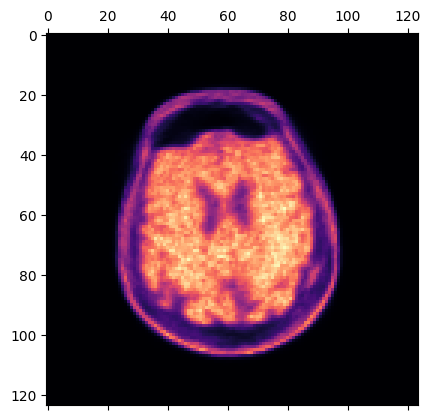

In [35]:
matshow(recortar(recon_mlem[-1][60,:,:]), cmap='magma')

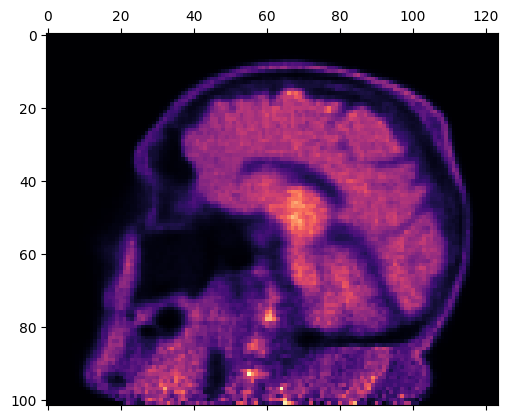

In [36]:
matshow(recorta2(recon_mlem[-1][:,:,175]), cmap='magma')

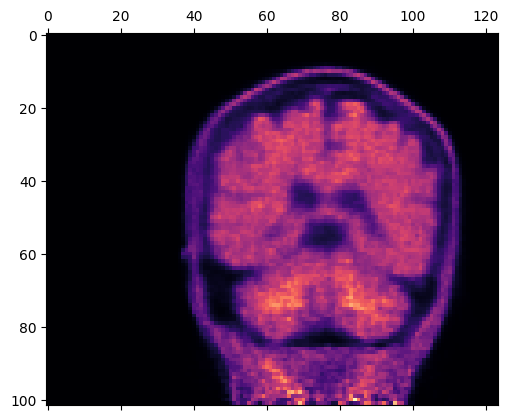

In [37]:

matshow(recorta2(recon_mlem[-1][:,175,:]), cmap='magma')

In [39]:
# guardamos los datos obtenidos de las reconstrucciones: recon_mlem
with open('datos_resultados/resultados_metrica_completa/recon_mlem_crit7.pickle', 'wb') as handle:
    pickle.dump(recon_mlem, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Guardamos los datos de los criterios de parada: datos_criterios_parada
with open('datos_resultados/resultados_metrica_completa/datos_iteraciones_crit7.pickle', 'wb') as handle:
    pickle.dump(datos_iteraciones, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [38]:
datos_iteraciones

[{'iteracion': -1, 'tiempo_iteracion': 0, 'MSE': 0, 'PSNR': 0, 'SSIM': 0},
 {'MSE': 0.031701969214307256,
  'PSNR': 18.671386065183754,
  'SSIM': 0.3473150623277852,
  'iteracion': 1,
  'tiempo_iteracion': 5.314671516418457},
 {'MSE': 0.0040930603046129095,
  'PSNR': 24.555319254210076,
  'SSIM': 0.683596161357421,
  'iteracion': 2,
  'tiempo_iteracion': 5.202745676040649},
 {'MSE': 0.00042241879716872977,
  'PSNR': 35.9935172237582,
  'SSIM': 0.8511123344827766,
  'iteracion': 3,
  'tiempo_iteracion': 5.153102397918701},
 {'MSE': 8.121500430599306e-05,
  'PSNR': 44.665146207148894,
  'SSIM': 0.9537477227620057,
  'iteracion': 4,
  'tiempo_iteracion': 5.16626238822937},
 {'MSE': 3.1758697382872726e-05,
  'PSNR': 50.98214411681166,
  'SSIM': 0.9869008469458344,
  'iteracion': 5,
  'tiempo_iteracion': 5.138171434402466},
 {'MSE': 2.9469230208268953e-05,
  'PSNR': 54.466675374688464,
  'SSIM': 0.9950760270594937,
  'iteracion': 6,
  'tiempo_iteracion': 5.1892101764678955},
 {'MSE': 9.3981

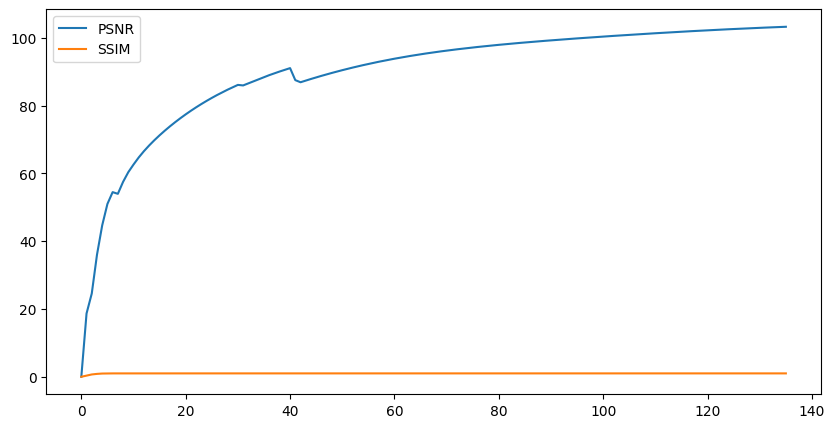

In [30]:
datos_criterios_parada_mse = [datos["MSE"] for datos in datos_iteraciones]
datos_criterios_parada_psnr = [datos["PSNR"] for datos in datos_iteraciones]
datos_criterios_parada_ssim = [datos["SSIM"] for datos in datos_iteraciones]

# datos_criterios_parada_ssim = datos_criterios_parada_ssim[4:]
# datos_criterios_parada_psnr = datos_criterios_parada_psnr[4:]
# datos_criterios_parada_mse = datos_criterios_parada_mse[4:]

# plot 
plt.figure(figsize=(10, 5))
# plt.plot(datos_criterios_parada_mse, label="MSE")
plt.plot(datos_criterios_parada_psnr, label="PSNR")
plt.plot(datos_criterios_parada_ssim, label="SSIM")

# legend
plt.legend()

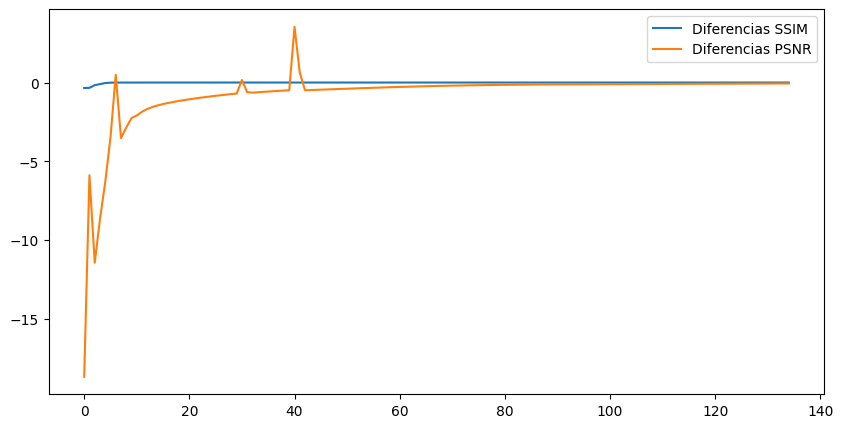

In [31]:
diferencias_ssim = [datos_criterios_parada_ssim[i] - datos_criterios_parada_ssim[i+1] for i in range(len(datos_criterios_parada_ssim)-1)]
diferencias_psnr = [datos_criterios_parada_psnr[i] - datos_criterios_parada_psnr[i+1] for i in range(len(datos_criterios_parada_psnr)-1)]

# plot
plt.figure(figsize=(10, 5))
plt.plot(diferencias_ssim[:], label="Diferencias SSIM")
plt.plot(diferencias_psnr[:], label="Diferencias PSNR")

# legend
plt.legend()

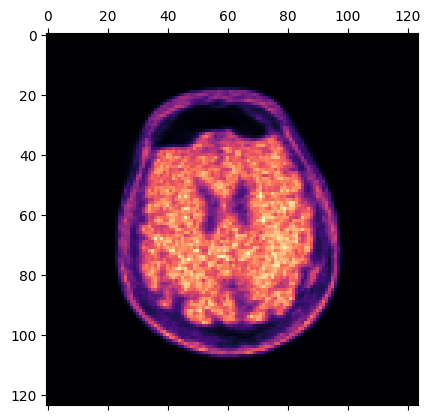

In [32]:
matshow(recortar(recon_mlem[-1][60,:,:]), cmap='magma')

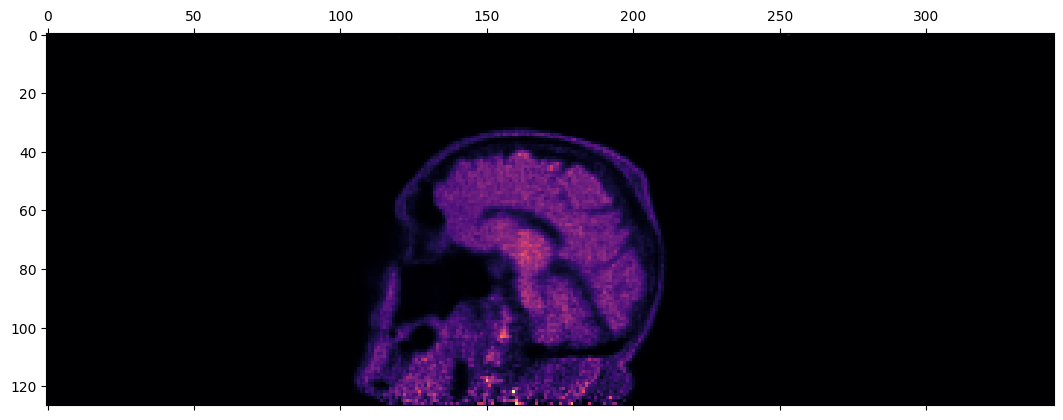

In [33]:
matshow(recon_mlem[-1][:,:,175], cmap='magma')

In [23]:
dato_objetivo = recon_mlem[-1]